In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

In [2]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
# get files

In [5]:
def load_data(path):
    x_train = []
    y_train = []
    yes_helmet_location=os.path.join(location,"yes_helmet")
    no_helmet_location=os.path.join(location,"no_helmet")
    yes_helmet_files=os.listdir(yes_helmet_location)
    no_helmet_files=os.listdir(no_helmet_location)
    
    for ffile in yes_helmet_files[:5000]:
        img=cv2.imread(os.path.join(yes_helmet_location,ffile))
        tr_x = image.img_to_array(img)
        tr_x = preprocess_input(tr_x)
        x_train.append(img)
        y_train.append(1)
    for ffile in no_helmet_files:
        img=cv2.imread(os.path.join(no_helmet_location,ffile))
        tr_x = image.img_to_array(img)
        tr_x = preprocess_input(tr_x)
        x_train.append(img)
        y_train.append(0)
    return np.array(x_train), to_categorical(y_train)

location="raw_yolo_keras/train/"
x_train, y_train = load_data(location)

print(type(y_train))
print(y_train.shape)    # 808,4
print(x_train.shape)    # 808,299,299,3

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

<class 'numpy.ndarray'>
(9874, 2)
(9874, 76, 76, 3)


### 1. Inception Resnet V2

In [ ]:
# reference: https://github.com/andrea-zanella/keras-transfer-learning-inception-resnetv2/blob/master/evaluate.py

In [ ]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet',  
                               input_shape=(76, 76, 3), pooling='avg')
for l in base_model.layers:
    l.trainable = False

input = Input(shape=(76, 76, 3))
t = base_model(input)
o = Dense(2, activation='softmax')(t)
model = Model(inputs=input, outputs=o)
    

    
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

model.summary()


batch_size = 48


n_epochs=50

# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=25)
csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

history = model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size,
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)

In [ ]:
model.evaluate(x_test,y_test
              )

In [ ]:
location="raw_yolo_keras/test/"
x_tester, y_tester = load_data(location)
model.evaluate(x_tester,y_tester)

In [ ]:
x_tester.shape

In [ ]:
plt.imshow(x_tester[-4])

In [ ]:
preds = model.predict(x_tester[-10:])
preds[:5]
y_tester[-10:]

In [ ]:
model.save("models/sixty_percent_just_inceptionresnetv2.h5")

### 2. VGG 16

In [ ]:
# base_model = VGG16(include_top=False, weights='imagenet',  
#                                input_shape=(76, 76, 3), pooling='avg')
# for l in base_model.layers:
#     l.trainable = False

# input = Input(shape=(76, 76, 3))
# t = base_model(input)
# o = Dense(2, activation='softmax')(t)
# model = Model(inputs=input, outputs=o)
    

    
# loss = tf.keras.losses.CategoricalCrossentropy()
# adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

# model.summary()


# batch_size = 48


# n_epochs=50

# # Callbacks
# es_callback = EarlyStopping(monitor='val_loss', patience=25)
# csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
# lr_callback = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
# )

# history = model.fit(
#     x_train,y_train, validation_data=(x_test,y_test), 
#     batch_size=batch_size,
#     epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
# )

In [3]:
model=load_model("models/ninety2_percent_just_vgg16.h5")

In [6]:
location="raw_yolo_keras/test/"
x_tester, y_tester = load_data(location)
model.evaluate(x_tester,y_tester)

213/213 [==============================] - 52s 243ms/step - loss: 0.2814 - accuracy: 0.9266


[0.2813810110092163, 0.9266499876976013]

In [12]:
preds = model.predict(x_tester[-5:])
print(preds[:5])
print(y_tester[-5:])

[[9.9923706e-01 7.6294324e-04]
 [9.9999213e-01 7.8647581e-06]
 [8.9631879e-01 1.0368121e-01]
 [9.9168915e-01 8.3109122e-03]
 [9.8948973e-01 1.0510274e-02]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


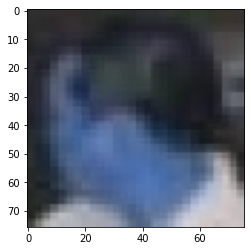

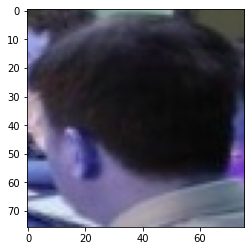

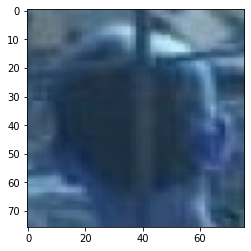

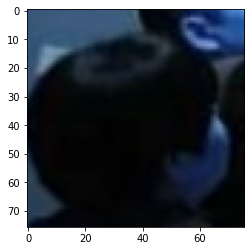

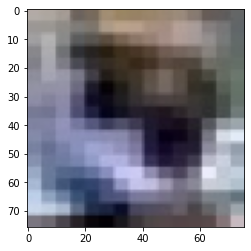

In [13]:
for img in x_tester[-5:]:
    plt.imshow(img)
    plt.show()

In [9]:
preds = model.predict(x_tester[:5])
print(preds[:5])
print(y_tester[:5])

[[2.6923349e-17 1.0000000e+00]
 [6.5937442e-08 9.9999988e-01]
 [1.1721635e-03 9.9882787e-01]
 [1.4690771e-18 1.0000000e+00]
 [2.7113535e-15 1.0000000e+00]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


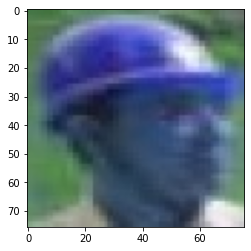

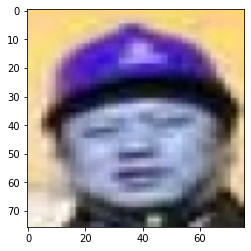

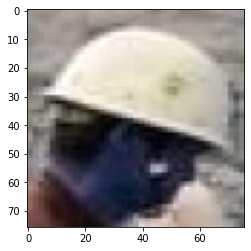

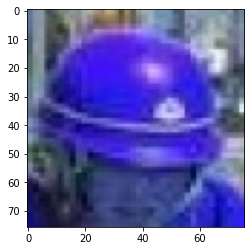

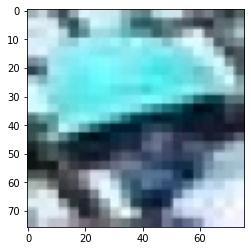

In [14]:
for img in x_tester[:5]:
    plt.imshow(img)
    plt.show()

In [ ]:
# model.save("models/ninety2_percent_just_vgg16.h5")

### InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(include_top=False, weights='imagenet',  
                               input_shape=(76, 76, 3), pooling='avg')
for l in base_model.layers:
    l.trainable = False

input = Input(shape=(76, 76, 3))
t = base_model(input)
o = Dense(2, activation='softmax')(t)
model = Model(inputs=input, outputs=o)
    

    
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

model.summary()


batch_size = 48


n_epochs=50

# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=25)
csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

history = model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size,
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)

In [ ]:
location="raw_yolo_keras/test/"
x_tester, y_tester = load_data(location)
model.evaluate(x_tester,y_tester)

In [ ]:
preds = model.predict(x_tester[-10:])
print(preds[:5])
print(y_tester[-5:])

In [ ]:
model.save("models/svnty9_percent_just_InceptionV3.h5")

In [ ]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet',  
                               input_shape=(76, 76, 3), pooling='avg')
for l in base_model.layers:
    l.trainable = False

input = Input(shape=(76, 76, 3))
t = base_model(input)
o = Dense(2000, activation='relu')(t)
o = Dense(2, activation='softmax')(o)
model = Model(inputs=input, outputs=o)
    

    
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

print(model.summary())


batch_size = 48


n_epochs=50

# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=25)
csv_logger = CSVLogger(os.path.join('eval','4_eval_resnet_pretrained.log'))
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

history = model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size,
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)